# Predicting Loan Payback

by: Muhammad Robith

Goal: Predict the probability that a borrower will pay back their loan.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import HistGradientBoostingClassifier

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import kruskal

from joblib import dump, load

## package versions:
# numpy 1.26.4
# pandas 2.2.3
# scikit-learn 1.2.2
# seaborn 0.12.2
# matplotlib 3.7.2
# scipy 1.15.3
# joblib 1.5.2

## Data Prep

### Load Data

In [2]:
data = pd.read_csv('/kaggle/input/playground-series-s5e11/train.csv')
display(data.head(5))
print(len(data))

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


593994


In [3]:
## drop id from columns
data = data.drop('id', axis=1)

## remove duplicated data
data = data.drop_duplicates()
display(data.head(5))
print(len(data))

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


593994


In [4]:
## inspect data types
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   annual_income         593994 non-null  float64
 1   debt_to_income_ratio  593994 non-null  float64
 2   credit_score          593994 non-null  int64  
 3   loan_amount           593994 non-null  float64
 4   interest_rate         593994 non-null  float64
 5   gender                593994 non-null  object 
 6   marital_status        593994 non-null  object 
 7   education_level       593994 non-null  object 
 8   employment_status     593994 non-null  object 
 9   loan_purpose          593994 non-null  object 
 10  grade_subgrade        593994 non-null  object 
 11  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 54.4+ MB


None

In [5]:
## remove data with target outside 0 or 1
data = data[(data['loan_paid_back']>=0) | (data['loan_paid_back']<=1)]
print(len(data))

593994


In [6]:
## remove negative income, ratios, amount and interest rate
numerik = ['annual_income', 'debt_to_income_ratio',
           'loan_amount', 'interest_rate']

for i in numerik:
    data = data[(data[i]>=0)]

print(len(data))

593994


### Separate feature and target

In [7]:
X_train = data.copy().drop('loan_paid_back', axis=1)
display(X_train.head(5))

y_train = data['loan_paid_back'].copy()
display(y_train.head(5))

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade
0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3
1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3
2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5
3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1
4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1


0    1.0
1    0.0
2    1.0
3    1.0
4    1.0
Name: loan_paid_back, dtype: float64

### Perform EDA

In [8]:
## look for nans
nan_df = X_train.isna().sum(0)
display(nan_df)

annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
dtype: int64

no nans, as mentioned in dataset description.

In [9]:
## now we check entries on object columns
objek = ['gender', 'marital_status', 'education_level',
         'employment_status', 'loan_purpose', 'grade_subgrade']

for i in objek:
    print(X_train[i].unique())

['Female' 'Male' 'Other']
['Single' 'Married' 'Divorced' 'Widowed']
['High School' "Master's" "Bachelor's" 'PhD' 'Other']
['Self-employed' 'Employed' 'Unemployed' 'Retired' 'Student']
['Other' 'Debt consolidation' 'Home' 'Education' 'Vacation' 'Car'
 'Medical' 'Business']
['C3' 'D3' 'C5' 'F1' 'D1' 'D5' 'C2' 'C1' 'F5' 'D4' 'C4' 'D2' 'E5' 'B1'
 'B2' 'F4' 'A4' 'E1' 'F2' 'B4' 'E4' 'B3' 'E3' 'B5' 'E2' 'F3' 'A5' 'A3'
 'A1' 'A2']


Note on categories:
* we have other in gender, education level, and loan purpose. We are going to assign them as NaN, so sklearn will deal them accordingly.

### Perform EDA on numericals

Here we plot numerical features' distribution in order to observe if all numerical features are normally distributed.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

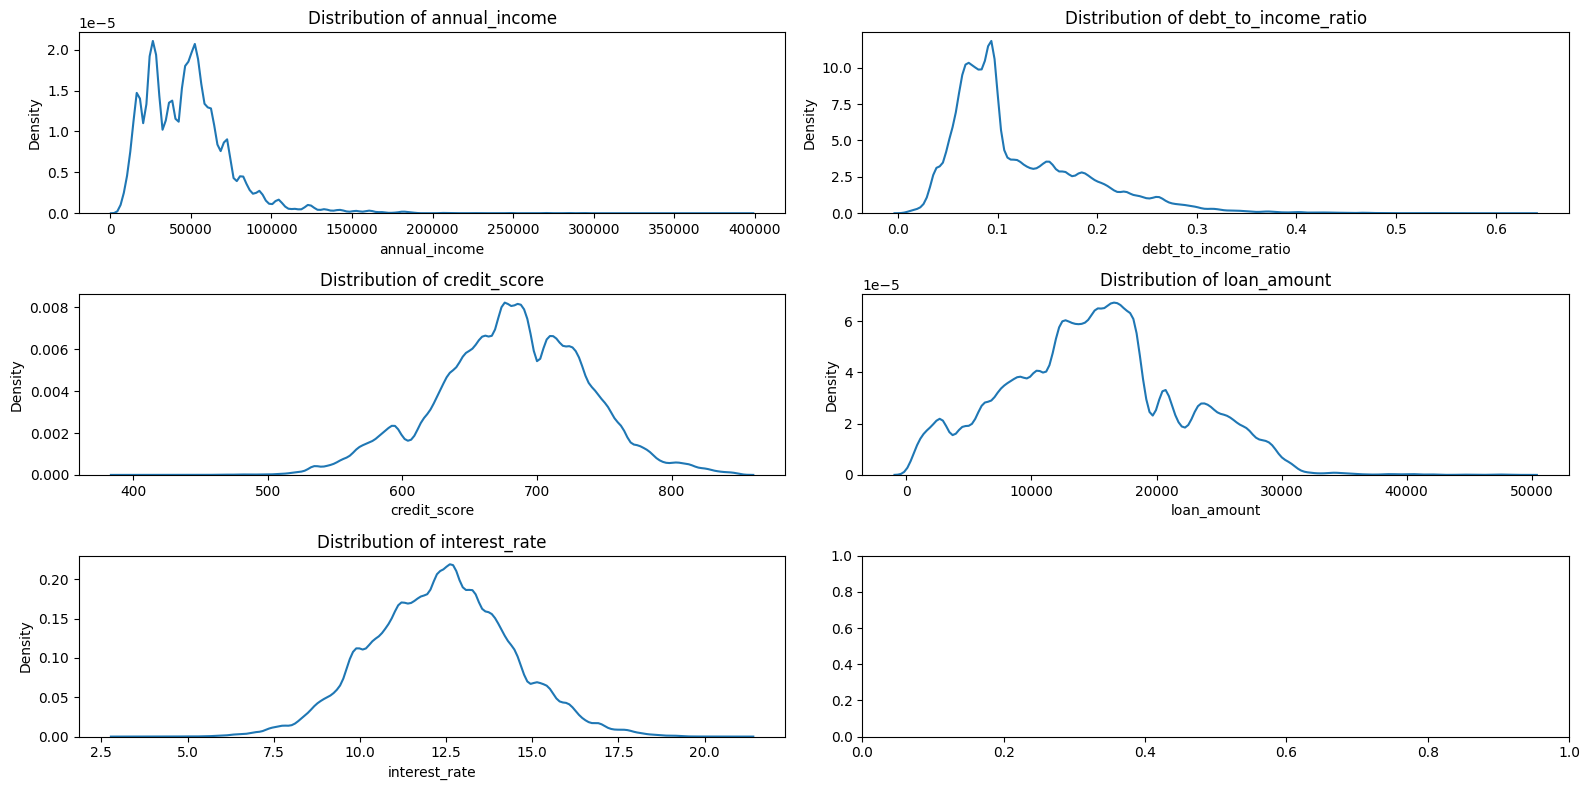

In [10]:
numerik = ['annual_income', 'debt_to_income_ratio',
           'credit_score', 'loan_amount',
           'interest_rate']

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 8))
axes = ax.flatten()

for i, col in enumerate(X_train[numerik].columns):
    sns.kdeplot(X_train[col], ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

The skewness of most features shows that those features has non-normal distribution.

## Data Preprocessing

### Ordinal Encoding

Here we do ordinal encoding to match Hist.GBT requirement for categorical feature.

In [11]:
objek = ['gender', 'marital_status', 'education_level',
         'employment_status', 'loan_purpose', 'grade_subgrade']

## perform Ordinal encoder for categoricals
g_cat = X_train['gender'].unique()
g_cat = np.delete(g_cat, np.where(g_cat=='Other')) ## assume Other as NaN
n_g   = len(g_cat)

ms_cat = X_train['marital_status'].unique()
n_ms = len(ms_cat)

el_cat = X_train['education_level'].unique()
el_cat = np.delete(el_cat, np.where(el_cat=='Other'))
n_el = len(el_cat)

es_cat = X_train['employment_status'].unique()
n_es = len(es_cat)

lp_cat = X_train['loan_purpose'].unique()
lp_cat = np.delete(lp_cat, np.where(lp_cat=='Other'))
n_lp = len(lp_cat)

grade_order = X_train['grade_subgrade'].unique()
grade_order = np.sort(grade_order)[::-1] ## might be ordinal
                            ## here we set the order is from worst to best
n_grade = len(grade_order)

# ## perform encoding
X_ord = X_train[objek]
kategori = [g_cat, ms_cat, el_cat, es_cat, lp_cat, grade_order]

display(X_ord.head())

enc = OrdinalEncoder(categories=kategori,
                     handle_unknown='use_encoded_value',
                     unknown_value=np.nan)
enc.fit(X_ord)

dump(enc, 'encoder.joblib') 

,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade
0,Female,Single,High School,Self-employed,Other,C3
1,Male,Married,Master's,Employed,Debt consolidation,D3
2,Male,Single,High School,Employed,Debt consolidation,C5
3,Female,Single,High School,Employed,Debt consolidation,F1
4,Male,Married,High School,Employed,Other,D1


['encoder.joblib']

In [12]:
## transform data
X_enc = enc.transform(X_ord)
X_enc = pd.DataFrame(X_enc, index=X_train.index,
                     columns=enc.get_feature_names_out())

## replace grade feature with encoded value
X_train = X_train.drop(objek, axis=1)
X_train = X_train.merge(X_enc, how='inner',
                        left_index=True, right_index=True) ## use index as keys

display(X_train.head())

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade
0,29367.99,0.084,736,2528.42,13.67,0.0,0.0,0.0,0.0,NaN,17.0
1,22108.02,0.166,636,4593.10,12.92,1.0,1.0,1.0,1.0,0.0,12.0
2,49566.20,0.097,694,17005.15,9.76,1.0,0.0,0.0,1.0,0.0,15.0
3,46858.25,0.065,533,4682.48,16.10,0.0,0.0,0.0,1.0,0.0,4.0
4,25496.70,0.053,665,12184.43,10.21,1.0,1.0,0.0,1.0,NaN,14.0


### Dealing with multicolinearity

Multicolinearity between numerical features means that there is a feature that behave similarly with other feature. This means that 1 of them are redundant, thus can be removed during our modelling. Due to non-normality of distribution, we are going to use Spearman correlation to measure colinearity between features.

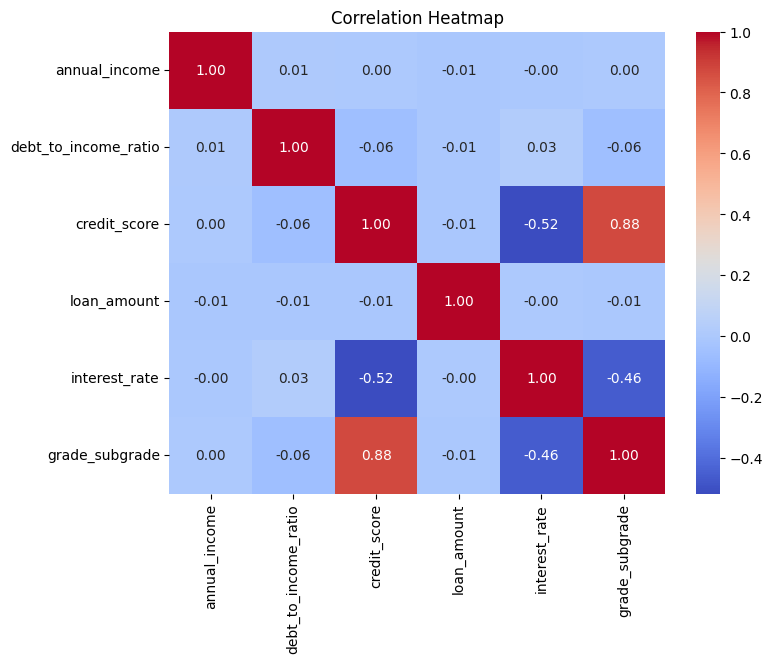

In [13]:
numerik = ['annual_income', 'debt_to_income_ratio',
           'credit_score', 'loan_amount',
           'interest_rate', 'grade_subgrade'] ## redefine numericals

corr_pd = X_train[numerik].corr(method='spearman')
plt.figure(figsize=(8, 6)) # Adjust figure size as needed
sns.heatmap(corr_pd, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Here we see that credit score is heavily correlated with grade and somewhat correlated with interest rate. Considering other correlations are fairly low, here we are ging to remove grade and interest_rate as features.

In [14]:
X_train = X_train.drop(['grade_subgrade', 'interest_rate'], axis=1)
display(X_train.head())

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,annual_income,debt_to_income_ratio,credit_score,loan_amount,gender,marital_status,education_level,employment_status,loan_purpose
0,29367.99,0.084,736,2528.42,0.0,0.0,0.0,0.0,NaN
1,22108.02,0.166,636,4593.10,1.0,1.0,1.0,1.0,0.0
2,49566.20,0.097,694,17005.15,1.0,0.0,0.0,1.0,0.0
3,46858.25,0.065,533,4682.48,0.0,0.0,0.0,1.0,0.0
4,25496.70,0.053,665,12184.43,1.0,1.0,0.0,1.0,NaN


## Modelling

Metric considered here is area under ROC curve.
The baseline considered here is "all 1" or "all 0".

In [15]:
## prepare strateifiedKFold split
skf = StratifiedKFold()
skf.split(X_train, y_train)

<generator object _BaseKFold.split at 0x7e21f752f2e0>

In [16]:
dummy = DummyClassifier(strategy='constant')

dummy_param = {'constant': [0, 1]}
# 0 means all 0 strategy
# 1 means all 1 strategy

best_dummy = GridSearchCV(dummy, dummy_param,
                          scoring='roc_auc',
                          cv=skf)

best_dummy.fit(X_train, y_train)

display(best_dummy)
dummy_valid = best_dummy.best_score_

print(f'Baseline training roc auc: {dummy_valid:.6f}')
print(best_dummy.best_params_)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DummyClassifier(strategy='constant'),
             param_grid={'constant': [0, 1]}, scoring='roc_auc')

Baseline training roc auc: 0.500000
{'constant': 0}


### Hist. GBT Model

Model considered here is Hist. Gradient Boosting. Hyperparameter considered are learning rate and max_leaf_nodes

Notes on preprocessing:
* No need for scaler since it is Tree ensemble (at least for now)
* No need for imputation since it is natively supported

3 phases of model fitting:
1. Feature Selection (consider RFE)
2. Monotonic Constraint
3. Hyperparam

#### Feature Selection

We conduct sequential-like feature selection in order to choose the best feature to be considered. This approach mimic forward sequential in 2 part: first part is measure the performance using only 1 feature, while second part adding features 1 at a time.

In [17]:
objek = ['gender', 'marital_status', 'education_level',
         'employment_status', 'loan_purpose'] ## redefine categorical data
        ## monotonic ordinal don't count as categorical

fsel_dict = {}
fsel_dict['Feature'] = []
fsel_dict['Perf.'] = []

## 1st phase: 1 feature only
for col in list(X_train.columns):
    X_train1 = X_train[col].to_frame()
    
    if col in objek:
        objek1 = [True]
    else:
        objek1 = [False]
    
    model = HistGradientBoostingClassifier(categorical_features=objek1,
                                           random_state=33) # define everytime

    hasil = cross_val_score(model, X_train1, y_train,
                            scoring='roc_auc',
                            cv=skf,
                            verbose=1)

    # print(np.mean(hasil))
    fsel_dict['Feature'].append(col)
    fsel_dict['Perf.'].append(np.mean(hasil))

fsel_df = pd.DataFrame(fsel_dict).sort_values(by='Perf.', ascending=False).reset_index(drop=True)
display(fsel_df)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.2s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   19.9s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.5s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   19.2s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.7s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.2s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.9s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.8s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.6s finished


,Feature,Perf.
0,employment_status,0.779103
1,debt_to_income_ratio,0.747482
2,credit_score,0.678997
3,loan_amount,0.553153
4,annual_income,0.546518
5,education_level,0.516481
6,loan_purpose,0.514700
7,gender,0.504390
8,marital_status,0.499593


In [18]:
# phase 2: add 1 item, 1 at a time
## use 1 feature only first
col = fsel_df.loc[0,'Feature']
if col in objek:
    objek2 = [True]
else:
    objek2 = [False]

fsel_dict = {}
fsel_dict['Added'] = []
fsel_dict['Perf.'] = []

## 1st step: best feature only
X_train2 = X_train[col].to_frame()

model = HistGradientBoostingClassifier(categorical_features=objek2,
                                       random_state=33) # define everytime

hasil = cross_val_score(model, X_train2, y_train,
                        scoring='roc_auc',
                        cv=skf,
                        verbose=1)

# print(np.mean(hasil))
fsel_dict['Added'].append(col)
fsel_dict['Perf.'].append(np.mean(hasil))
best_obj  = np.mean(hasil)
best_feat = col
best_objek2 = objek2

## 2nd step: add 1 at a time
for k in range(len(fsel_df)-1):
    all_col = list(fsel_df.loc[0:(k+1),'Feature'])
    add_col = fsel_df.loc[k+1,'Feature']
    X_train2 = X_train[all_col]
    if add_col in objek:
        objek2.append(True)
    else:
        objek2.append(False)

    model = HistGradientBoostingClassifier(categorical_features=objek2,
                                           random_state=33) # define everytime
    
    hasil = cross_val_score(model, X_train2, y_train,
                            scoring='roc_auc',
                            cv=skf,
                            verbose=1)

    fsel_dict['Added'].append(add_col)
    fsel_dict['Perf.'].append(np.mean(hasil))
    if np.mean(hasil) > best_obj:
        best_obj = np.mean(hasil)
        best_feat = all_col
        best_objek2 = objek2

fsel_2 = pd.DataFrame(fsel_dict)
display(fsel_2)
print(best_feat)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.0s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.5s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.3s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.7s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.6s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.8s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.9s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.5s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   27.0s finished


,Added,Perf.
0,employment_status,0.779103
1,debt_to_income_ratio,0.892521
2,credit_score,0.919179
3,loan_amount,0.919198
4,annual_income,0.919185
5,education_level,0.918986
6,loan_purpose,0.918998
7,gender,0.918907
8,marital_status,0.918768


['employment_status', 'debt_to_income_ratio', 'credit_score', 'loan_amount']


use features obtained during feature selection

In [19]:
X_train = X_train[best_feat]
objek = best_objek2[0:len(best_feat)]

display(X_train.head())
print(objek)

,employment_status,debt_to_income_ratio,credit_score,loan_amount
0,0.0,0.084,736,2528.42
1,1.0,0.166,636,4593.10
2,1.0,0.097,694,17005.15
3,1.0,0.065,533,4682.48
4,1.0,0.053,665,12184.43


[True, False, False, False]


#### Monotonic constraint

Here we consider eps-square method to determine association between class and numericals. This step consist of 2 parts: Determine association between numericals and target using epsilon-squared, then test if monotonic constraint improves prediction quality, start from not using monotonic constraint, then add the most associated features 1 at the time.

In [20]:
## get all numerical columns
numerik = list(X_train.columns)
new_numerik = []
for i in range(len(numerik)):
    print(numerik[i])
    if objek[i]==False:
        new_numerik.append(numerik[i])

numerik = new_numerik
print(numerik)

mcon_1 = {}
mcon_1['Feature'] = []
mcon_1['H-stat'] = []
mcon_1['Direction'] = []

## determine association
for val in numerik:
    Xy = pd.merge(X_train[val].to_frame(), y_train.to_frame(),
                  how='inner',
                  left_index=True, right_index=True)

    Xyg = Xy.groupby('loan_paid_back')
    Xy0 = Xyg.get_group(0.0)[val].to_numpy()
    Xy1 = Xyg.get_group(1.0)[val].to_numpy()

    hasil = kruskal(Xy0, Xy1)

    ## deterimine direction of constraint
    med0 = np.median(Xy0)
    med1 = np.median(Xy1)

    if med0 < med1:
        mcon_1['Feature'].append(val)
        mcon_1['H-stat'].append(hasil.statistic)
        mcon_1['Direction'].append(1)
    elif med0 > med1:
        mcon_1['Feature'].append(val)
        mcon_1['H-stat'].append(hasil.statistic)
        mcon_1['Direction'].append(-1)

mcon_1 = pd.DataFrame(mcon_1)
mcon_1 = mcon_1.sort_values(by='H-stat', ascending=False).reset_index(drop=True)

display(mcon_1)

employment_status
debt_to_income_ratio
credit_score
loan_amount
['debt_to_income_ratio', 'credit_score', 'loan_amount']


,Feature,H-stat,Direction
0,debt_to_income_ratio,53088.189219,-1
1,credit_score,33557.165507,1
2,loan_amount,17.933501,-1


In [21]:
## step 2: Tests
## test without m.constraint
mcon_2 = {}
mcon_2['Added'] = []
mcon_2['Perf.'] = []

model = HistGradientBoostingClassifier(categorical_features=objek,
                                       random_state=33) # define everytime

hasil = cross_val_score(model, X_train, y_train,
                        scoring='roc_auc',
                        cv=skf,
                        verbose=1)

# print(np.mean(hasil))
mcon_2['Added'].append('None')
mcon_2['Perf.'].append(np.mean(hasil))
best_obj  = np.mean(hasil)
best_feat2 = None

buff_dict = {} ##dict for mon. cosntraint

for k in range(len(mcon_1)):
    fitur = mcon_1.loc[k, 'Feature']
    arah  = mcon_1.loc[k, 'Direction']
    buff_dict[fitur] = arah
    print(buff_dict)

    model = HistGradientBoostingClassifier(categorical_features=objek,
                                           monotonic_cst=buff_dict,
                                           random_state=33) # define everytime
    
    hasil = cross_val_score(model, X_train, y_train,
                            scoring='roc_auc',
                            cv=skf,
                            verbose=1)
    
    # print(np.mean(hasil))
    mcon_2['Added'].append(fitur)
    mcon_2['Perf.'].append(np.mean(hasil))
    if np.mean(hasil) > best_obj:
        best_obj = np.mean(hasil)
        best_feat2 = buff_dict

mcon_2 = pd.DataFrame(mcon_2)
display(mcon_2)
print(best_obj)
print(best_feat2)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.7s finished


{'debt_to_income_ratio': -1}


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.1s finished


{'debt_to_income_ratio': -1, 'credit_score': 1}


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.9s finished


{'debt_to_income_ratio': -1, 'credit_score': 1, 'loan_amount': -1}


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.4s finished


,Added,Perf.
0,None,0.919198
1,debt_to_income_ratio,0.915241
2,credit_score,0.914603
3,loan_amount,0.913842


0.9191982356039367
None


conclude the result

In [22]:
best_mcon = best_feat2
print(best_mcon)

None


In [23]:
display(model)

HistGradientBoostingClassifier(categorical_features=[True, False, False, False],
                               monotonic_cst={'credit_score': 1,
                                              'debt_to_income_ratio': -1,
                                              'loan_amount': -1},
                               random_state=33)

before doing hyperparam, re-do CV on best feature and best mon. constraint

In [24]:
print(best_feat)
print(objek)
print(best_mcon)

dump(best_feat, 'features.joblib')
dump(objek, 'categoricals.joblib')
dump(best_mcon, 'motonics.joblib')

model_nohyper = HistGradientBoostingClassifier(categorical_features=objek,
                                               monotonic_cst=best_mcon,
                                               random_state=33) # define everytime

model_nohyper.fit(X_train, y_train)

nohyper = cross_val_score(model_nohyper, X_train, y_train,
                          scoring='roc_auc',
                          cv=skf)

print(f"no-tuning CV ROC AUC score: {np.mean(nohyper):6f}")

['employment_status', 'debt_to_income_ratio', 'credit_score', 'loan_amount']
[True, False, False, False]
None
no-tuning CV ROC AUC score: 0.919198


#### hyperparameter tuning

Now we see if hyperparam tuning improve prediction

In [25]:
model = HistGradientBoostingClassifier(categorical_features=objek,
                                       monotonic_cst=best_mcon,
                                       random_state=33)

## determine model param
model_param = {'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.14, 0.2, 0.3],
               'max_iter': [100, 200, 500, 1000],
               'max_leaf_nodes': [(2**i - 1) for i in range(3,10)],
               'class_weight': [None, 'balanced']}
## notes: hyperparams are learning rate and max_leaf_node

best_model =       GridSearchCV(model, model_param,
                                n_jobs=-1,
                                cv=skf,
                                scoring='roc_auc',
                                verbose=2)

best_model.fit(X_train, y_train)

display(best_model)
model_valid = best_model.best_score_

print(f'HistGBT training roc auc: {model_valid:.6f}')

Fitting 5 folds for each of 392 candidates, totalling 1960 fits
[CV] END class_weight=None, learning_rate=0.01, max_iter=100, max_leaf_nodes=7; total time=  10.2s
[CV] END class_weight=None, learning_rate=0.01, max_iter=100, max_leaf_nodes=15; total time=  11.9s
[CV] END class_weight=None, learning_rate=0.01, max_iter=100, max_leaf_nodes=31; total time=  13.4s
[CV] END class_weight=None, learning_rate=0.01, max_iter=100, max_leaf_nodes=63; total time=  15.4s
[CV] END class_weight=None, learning_rate=0.01, max_iter=100, max_leaf_nodes=63; total time=  15.5s
[CV] END class_weight=None, learning_rate=0.01, max_iter=100, max_leaf_nodes=127; total time=  18.1s
[CV] END class_weight=None, learning_rate=0.01, max_iter=100, max_leaf_nodes=255; total time=  21.3s
[CV] END class_weight=None, learning_rate=0.01, max_iter=100, max_leaf_nodes=511; total time=  27.1s
[CV] END class_weight=None, learning_rate=0.01, max_iter=200, max_leaf_nodes=7; total time=  18.8s
[CV] END class_weight=None, learnin

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=HistGradientBoostingClassifier(categorical_features=[True,
                                                                            False,
                                                                            False,
                                                                            False],
                                                      random_state=33),
             n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.14, 0.2,
                                           0.3],
                         'max_iter': [100, 200, 500, 1000],
                         'max_leaf_nodes': [7, 15, 31, 63, 127, 255, 511]},
             scoring='roc_auc', verbose=2)

HistGBT training roc auc: 0.920060


In [26]:
## back to simple model if best model has worse result
print(model_valid)
print(np.mean(nohyper))
if model_valid < np.mean(nohyper):
    best_model = model_nohyper

## saving the best model
dump(best_model, 'best_model.joblib') 

0.920060481705051
0.9191982356039367


['best_model.joblib']

## Quick Evaluation (On training)

Here we see how Hist.GBT compare against all 0 strategy

In [27]:
model_pred = best_model.predict_proba(X_train)[:,1]
dummy_pred = best_dummy.predict_proba(X_train)[:,1]

model_score = roc_auc_score(y_train, model_pred)
dummy_score = roc_auc_score(y_train, dummy_pred)

print(f"Hist.GBT roc_auc score: {model_score:.6f}")
print(f'   All 0 roc_auc score: {dummy_score:.6f}')

Hist.GBT roc_auc score: 0.922482
   All 0 roc_auc score: 0.500000


Hist.GBT reach better score against all 0

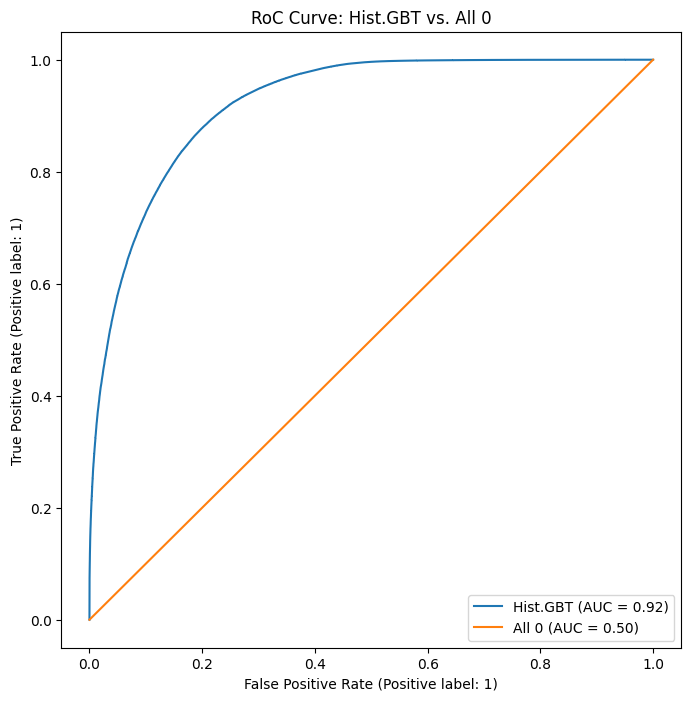

In [28]:
## now we plot roc curve
fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

RocCurveDisplay.from_predictions(y_train, model_pred,
                                 name='Hist.GBT',
                                 ax=ax1)
RocCurveDisplay.from_predictions(y_train, dummy_pred,
                                 name='All 0',
                                 ax=ax1)
plt.title('RoC Curve: Hist.GBT vs. All 0')

plt.show()

## Prepare Prediction

Here we are going to perform data preprocessing and predict target on test data

In [29]:
## load test data
Xt = pd.read_csv('/kaggle/input/playground-series-s5e11/test.csv')
display(Xt.head(5))
print(len(Xt))

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade
0,593994,28781.05,0.049,626,11461.42,14.73,Female,Single,High School,Employed,Other,D5
1,593995,46626.39,0.093,732,15492.25,12.85,Female,Married,Master's,Employed,Other,C1
2,593996,54954.89,0.367,611,3796.41,13.29,Male,Single,Bachelor's,Employed,Debt consolidation,D1
3,593997,25644.63,0.110,671,6574.30,9.57,Female,Single,Bachelor's,Employed,Debt consolidation,C3
4,593998,25169.64,0.081,688,17696.89,12.80,Female,Married,PhD,Employed,Business,C1


254569


In [30]:
## separate id and feature
Xtid = Xt['id'].copy()
Xt = Xt.drop('id', axis=1)

## remove duplicated data
Xt = Xt.drop_duplicates()
display(Xt.head(5))
print(len(Xt))

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade
0,28781.05,0.049,626,11461.42,14.73,Female,Single,High School,Employed,Other,D5
1,46626.39,0.093,732,15492.25,12.85,Female,Married,Master's,Employed,Other,C1
2,54954.89,0.367,611,3796.41,13.29,Male,Single,Bachelor's,Employed,Debt consolidation,D1
3,25644.63,0.110,671,6574.30,9.57,Female,Single,Bachelor's,Employed,Debt consolidation,C3
4,25169.64,0.081,688,17696.89,12.80,Female,Married,PhD,Employed,Business,C1


254569


In [31]:
# ## perform encoding
objek = ['gender', 'marital_status', 'education_level',
         'employment_status', 'loan_purpose', 'grade_subgrade']

Xt_ord = Xt[objek]
Xt_enc = enc.transform(Xt_ord)
Xt_enc = pd.DataFrame(Xt_enc, index=Xt.index,
                      columns=enc.get_feature_names_out())

## replace grade feature with encoded value
Xt = Xt.drop(objek, axis=1)
Xt = Xt.merge(Xt_enc, how='inner',
              left_index=True, right_index=True) ## use index as keys

## pick features due to feature selection
Xt = Xt[best_feat]

display(Xt.head())

,employment_status,debt_to_income_ratio,credit_score,loan_amount
0,1.0,0.049,626,11461.42
1,1.0,0.093,732,15492.25
2,1.0,0.367,611,3796.41
3,1.0,0.110,671,6574.30
4,1.0,0.081,688,17696.89


In [32]:
## get prediction
prediction = best_model.predict_proba(Xt)
pred = prediction[:,1]

# make csv
pred_df = pd.DataFrame(pred, index=Xtid, columns=['loan_paid_back'])
display(pred_df)
pred_df = pred_df.reset_index().to_csv('pred.csv', index=False)

,loan_paid_back
id,
593994,0.760629
593995,0.927093
593996,0.207138
593997,0.710732
593998,0.817079
...,...
848558,0.975325
848559,0.534836
848560,0.874322


In [33]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session